- Take the microarray data for Huh7 and PLc
- Average the two datasets for Huh7
- Map the genes to Recon3D
- Explore metabolic gene scores
- Assign max. score to missing genes
- Save as a new dataset

# Setup

In [1]:
import pandas as pd
import numpy as np
import cobra
import pickle
import matplotlib.pyplot as plt

import mygene
mg = mygene.MyGeneInfo()

In [2]:
out = mg.querymany(['fig|1149132.3.peg.30'], scopes=None, fields=None, species='human')
out

querying 1-1...done.
Finished.
2 input query terms found no hit:
	['fig', '1149132.3.peg.30']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


[{'query': 'fig', 'notfound': True},
 {'query': '1149132.3.peg.30', 'notfound': True}]

# Read the transcriptomics

In [3]:
df_data = pd.read_csv('../Data/microarray_MERAV_all_genes_batch_adjusted_RAW_146.50.70.125.txt',sep='\t', index_col=0)
df_data.columns = ['Huh7_exp1','Huh7_exp2', 'PLC']

# Remove '?' gene ID rows
df_data = df_data.drop('?') # we cannot do anything with this

# Take the mean of the two Huh7 datasets
df_data['Huh7'] = df_data[['Huh7_exp1','Huh7_exp2']].mean(axis=1)
df_data = df_data[['Huh7','PLC']]

print('Imported dataframe size:',len(df_data))
df_data.head()

Imported dataframe size: 17726


,Huh7,PLC
GENE,,
AKT3,25.100,23.32
MED6,410.770,288.05
NR2E3,24.775,22.58
NAALAD2,94.785,13.46
CDKN2B-AS1,33.695,28.35


# Get the list of metabolic genes from Recon3D

In [4]:
model = cobra.io.load_matlab_model('../Models/Recon3DModel_301.mat')

l_genes_full = [g.id for g in model.genes]
l_genes = [g.id.split('.')[0] for g in model.genes]

# Set up the dataframe

In [5]:
df = pd.DataFrame(index=l_genes,columns=['Huh7','PLC','Symbol','Alias','Name'])

# Query from entrezgene to gene symbols, alias and name
This query yields 3 genes that are not found: 0 does not exist, the other two missing genes have been withdrawn from NCBI.

The warning about duplicates is due to the fact that the input entrez gene list contains duplicates.

In [6]:
out = mg.querymany(l_genes, scopes='entrezgene', fields='symbol,alias,name', species='human')

df = pd.DataFrame(out)[['query','symbol','alias','name']]
df.columns = ['Entrez','Symbol','Alias','Name']
df = df.set_index('Entrez')

df['Huh7'] = np.nan
df['PLC'] = np.nan

# reset index to full gene IDs
df.index = l_genes_full

df.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2248...done.
Finished.
237 input query terms found dup hits:
	[('314', 2), ('6818', 3), ('3948', 2), ('57835', 4), ('4967', 2), ('1312', 2), ('18', 2), ('51166', 
3 input query terms found no hit:
	['100507855', '8041', '0']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


,Symbol,Alias,Name,Huh7,PLC
314.1,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,NaN,NaN
314.2,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,NaN,NaN
26.1,AOC1,"[ABP, ABP1, DAO, DAO1, KAO]",amine oxidase copper containing 1,NaN,NaN
8639.1,AOC3,"[HPAO, SSAO, VAP-1, VAP1]",amine oxidase copper containing 3,NaN,NaN
1591.1,CYP24A1,"[CP24, CYP24, HCAI, HCINF1, P450-CC24]",cytochrome P450 family 24 subfamily A member 1,NaN,NaN


# Match the symbol column to the dataset and save the TPM scores

In [7]:
count = 0
for indx,row in df.iterrows():
    s = df.at[indx,'Symbol']
    
    if s in df_data.index:
        v = df_data.loc[s,['Huh7','PLC']]
        df.at[indx,['Huh7','PLC']] = v
    else:
        count += 1

print('Could not find', count, 'gene symbols in the dataset')
df.head()

Could not find 220 gene symbols in the dataset


,Symbol,Alias,Name,Huh7,PLC
314.1,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,56.975,42.32
314.2,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,56.975,42.32
26.1,AOC1,"[ABP, ABP1, DAO, DAO1, KAO]",amine oxidase copper containing 1,26.660,24.28
8639.1,AOC3,"[HPAO, SSAO, VAP-1, VAP1]",amine oxidase copper containing 3,33.605,45.87
1591.1,CYP24A1,"[CP24, CYP24, HCAI, HCINF1, P450-CC24]",cytochrome P450 family 24 subfamily A member 1,12.975,614.13


In [8]:
missing = df[df['Huh7'].isnull() | df['PLC'].isnull()].index.tolist()

for indx in missing:
    aliases = df.at[indx,'Alias']
    
    if type(aliases) == float:
        continue
    
    for alias in aliases:
        if alias in df_data.index:
            v = df_data.loc[alias,['Huh7','PLC']]
            df.at[indx,['Huh7','PLC']] = v
            break
            
missing = df[df['Huh7'].isnull() | df['PLC'].isnull()].index.tolist()
print('After alias searching we are left with', len(missing),'remaining missing genes.')

df.loc[missing]

After alias searching we are left with 132 remaining missing genes.


,Symbol,Alias,Name,Huh7,PLC
6818.1,SULT1A3,"[HAST, HAST3, M-PST, ST1A3, ST1A3/ST1A4, ST1A4...",sulfotransferase family 1A member 3,NaN,NaN
3939.1,LDHA,"[GSD11, HEL-S-133P, LDHM, PIG19]",lactate dehydrogenase A,NaN,NaN
6818.2,SULT1A3,"[HAST, HAST3, M-PST, ST1A3, ST1A3/ST1A4, ST1A4...",sulfotransferase family 1A member 3,NaN,NaN
6818.3,SULT1A3,"[HAST, HAST3, M-PST, ST1A3, ST1A3/ST1A4, ST1A4...",sulfotransferase family 1A member 3,NaN,NaN
140838.1,NANP,"[C20orf147, HDHD4, dJ694B14.3]",N-acetylneuraminic acid phosphatase,NaN,NaN
438.1,ASMT,"[ASMTY, HIOMT, HIOMTY]",acetylserotonin O-methyltransferase,NaN,NaN
111.1,ADCY5,"[AC5, FDFM]",adenylate cyclase 5,NaN,NaN
137964.1,GPAT4,"[1-AGPAT 6, AGPAT6, LPAAT-zeta, LPAATZ, TSARG7]",glycerol-3-phosphate acyltransferase 4,NaN,NaN
340024.1,SLC6A19,"[B0AT1, HND]",solute carrier family 6 member 19,NaN,NaN
276.1,AMY1A,AMY1,amylase alpha 1A (salivary),NaN,NaN


# Calculate the fold-change from Huh7 to PLC

In [9]:
# calculate Fold_change and remove zeros and infinities
df['Fold_change'] = df['PLC'] / df['Huh7']
df[df['Fold_change'] > 1e7]['Fold_change'] = 999999 # to avoid infinity from X/0
df.head()

,Symbol,Alias,Name,Huh7,PLC,Fold_change
314.1,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,56.975,42.32,0.742782
314.2,AOC2,"[DAO2, RAO, SSAO]",amine oxidase copper containing 2,56.975,42.32,0.742782
26.1,AOC1,"[ABP, ABP1, DAO, DAO1, KAO]",amine oxidase copper containing 1,26.660,24.28,0.910728
8639.1,AOC3,"[HPAO, SSAO, VAP-1, VAP1]",amine oxidase copper containing 3,33.605,45.87,1.364975
1591.1,CYP24A1,"[CP24, CYP24, HCAI, HCINF1, P450-CC24]",cytochrome P450 family 24 subfamily A member 1,12.975,614.13,47.331792


# Looking at the mean and median expression levels

In [10]:
print(df.PLC.mean(), df.Huh7.mean())
print(df_data.PLC.mean(), df_data.Huh7.mean())

540.6846077504739 528.5138019848774
339.5883278799497 341.7853923615027


In [11]:
print(df.PLC.median(), df.Huh7.median())
print(df_data.PLC.median(), df_data.Huh7.median())

125.94999999999999 140.3875
97.12 98.4025


# Analyzing statistics of the metabolic genes in detail

Number of genes with zero TPM in both cell lines: 0
Number of genes with TPMs below the median in both cell lines: 784
Number of genes expressed above the median in both cell lines: 1070
Number of genes expressed above the mean in both cell lines: 530
Number of expressed genes with a >3x fold-change: 199


/Users/thierry/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824 RuntimeWarning: invalid value encountered in greater_equal
/Users/thierry/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825 RuntimeWarning: invalid value encountered in less_equal


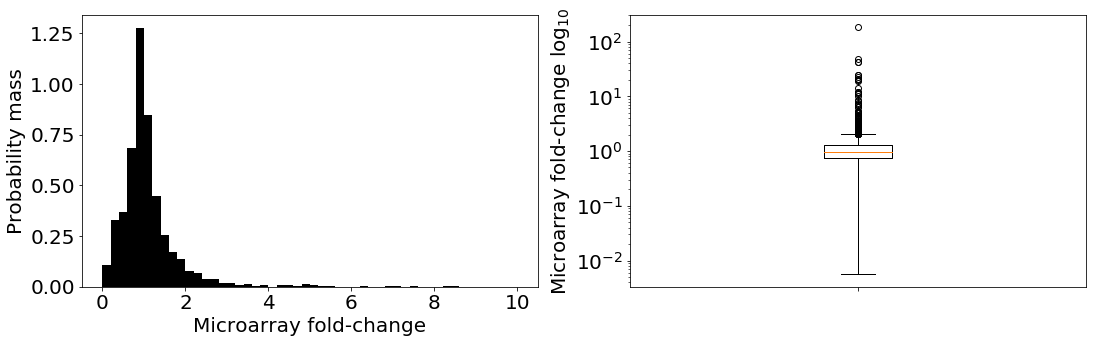

In [12]:
# find common non-expressed genes
df_zeros = df[(df['Huh7']==0) & (df['PLC']==0)]
print('Number of genes with zero TPM in both cell lines:',len(df_zeros))

# find common low expression genes (below median)
t = df_data[['Huh7','PLC']].quantile(0.5).values
df_low = df[(df['Huh7']>0) & (df['PLC']>0)]
df_low = df_low[(df_low['Huh7']<t[0]) & (df_low['PLC']<t[1])]
print('Number of genes with TPMs below the median in both cell lines:',len(df_low))

# find all common (somewhat) expressed metabolic genes
df_expr = df[(df['Huh7']>=t[0]) & (df['PLC']>=t[1])]
print('Number of genes expressed above the median in both cell lines:',len(df_expr))

# find all common highly expressed metabolic genes
t = df_data[['Huh7','PLC']].mean().values
df_high = df[(df['Huh7']>=t[0]) & (df['PLC']>=t[1])]
print('Number of genes expressed above the mean in both cell lines:',len(df_high))

# find all genes that are expressed (> median) in at least 1 cell line and have a substantial fold-change
t = df_data[['Huh7','PLC']].quantile(0.5).values
df_expr = df[(df['Huh7']>=t[0]) | (df['PLC']>=t[1])]
df_expr_fc = df_expr[(df_expr['Fold_change']>3) | (df_expr['Fold_change']<0.333)]
print('Number of expressed genes with a >3x fold-change:',len(df_expr_fc))

plt.rc('font', size=20)
fig, (ax1,ax2)= plt.subplots(1, 2)
fig.set_size_inches(18,5)

ax1.hist(df['Fold_change'].values,bins=50, normed=True, range=(0,10),color='k') 
ax1.set_xlabel('Microarray fold-change')
ax1.set_ylabel('Probability mass')

bp = ax2.boxplot(df[~df['Fold_change'].isna()]['Fold_change'].values)
ax2.set_xticklabels('')
ax2.set_yscale('log')
ax2.set_ylabel(r'Microarray fold-change $\log_{10}$')

fig.savefig('../Figures/Microarray_fold_change_PMF.png',bbox_inches = 'tight')
plt.show()

# assign the maximum score to the missing genes

In [13]:
df.loc[missing,['Huh7','PLC']] = df[['Huh7','PLC']].max().values
df.loc[missing]

,Symbol,Alias,Name,Huh7,PLC,Fold_change
6818.1,SULT1A3,"[HAST, HAST3, M-PST, ST1A3, ST1A3/ST1A4, ST1A4...",sulfotransferase family 1A member 3,17484.39,22311.5,NaN
3939.1,LDHA,"[GSD11, HEL-S-133P, LDHM, PIG19]",lactate dehydrogenase A,17484.39,22311.5,NaN
6818.2,SULT1A3,"[HAST, HAST3, M-PST, ST1A3, ST1A3/ST1A4, ST1A4...",sulfotransferase family 1A member 3,17484.39,22311.5,NaN
6818.3,SULT1A3,"[HAST, HAST3, M-PST, ST1A3, ST1A3/ST1A4, ST1A4...",sulfotransferase family 1A member 3,17484.39,22311.5,NaN
140838.1,NANP,"[C20orf147, HDHD4, dJ694B14.3]",N-acetylneuraminic acid phosphatase,17484.39,22311.5,NaN
438.1,ASMT,"[ASMTY, HIOMT, HIOMTY]",acetylserotonin O-methyltransferase,17484.39,22311.5,NaN
111.1,ADCY5,"[AC5, FDFM]",adenylate cyclase 5,17484.39,22311.5,NaN
137964.1,GPAT4,"[1-AGPAT 6, AGPAT6, LPAAT-zeta, LPAATZ, TSARG7]",glycerol-3-phosphate acyltransferase 4,17484.39,22311.5,NaN
340024.1,SLC6A19,"[B0AT1, HND]",solute carrier family 6 member 19,17484.39,22311.5,NaN
276.1,AMY1A,AMY1,amylase alpha 1A (salivary),17484.39,22311.5,NaN


# Export the dataframe

In [14]:
df.to_csv('../Data/microarray_data_with_entrez_genes.csv', sep="\t", index_label='gene')